1: Project Setup & Library Imports


In [ ]:
# 1.1 Import Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import joblib
import warnings

# 1.2 Import Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

# 1.3 Configuration
# Ignore warnings for a cleaner output
warnings.filterwarnings('ignore')
# Set plot style
sns.set(style="whitegrid")
print("Libraries Imported Successfully")

Libraries Imported Successfully


Section 2: Data Ingestion (SQL Simulation)

Demonstrates the ability to handle databases. We convert the CSV to a SQL database first, then query it.

In [ ]:
# 2.1 Load Raw Data
# Ensure 'dataset.csv' is uploaded to your Colab session
dataset_path = 'dataset.csv'
try:
    df_raw = pd.read_csv(dataset_path, sep=',') # Adjust separator if needed (e.g., ';')
    print(f"File loaded. Shape: {df_raw.shape}")
except FileNotFoundError:
    print(" Error: 'dataset.csv' not found. Please upload the file.")

# 2.2 Create Local SQL Database (Simulation)
conn = sqlite3.connect('students_db.sqlite')
df_raw.to_sql('students_performance', conn, if_exists='replace', index=False)
print(" SQL Database created and data populated.")

# 2.3 SQL Query to Retrieve Data
# We act as if we are querying an enterprise database
query = """
SELECT *
FROM students_performance
WHERE "Age at enrollment" >= 18
"""

df = pd.read_sql(query, conn)
conn.close()

# 2.4 Quick Data Inspection
print("\n--- Data Sample (From SQL) ---")
print(df.head())
print(f"\nTotal Records Retrieved: {df.shape[0]}")

File loaded. Shape: (4424, 35)
 SQL Database created and data populated.

--- Data Sample (From SQL) ---
   Marital status  Application mode  Application order  Course  \
0               1                 8                  5       2   
1               1                 6                  1      11   
2               1                 1                  5       5   
3               1                 8                  2      15   
4               2                12                  1       3   

   Daytime/evening attendance  Previous qualification  Nacionality  \
0                           1                       1            1   
1                           1                       1            1   
2                           1                       1            1   
3                           1                       1            1   
4                           0                       1            1   

   Mother's qualification  Father's qualification  Mother's occupation  ...  

3: Exploratory Data Analysis (EDA) & Preprocessing

Checking the target distribution and preparing data for the model.

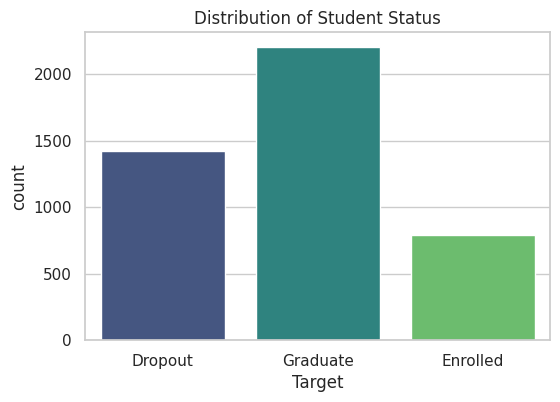

In [ ]:
# 3.1 Check Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Target', data=df, palette='viridis')
plt.title('Distribution of Student Status')
plt.show()

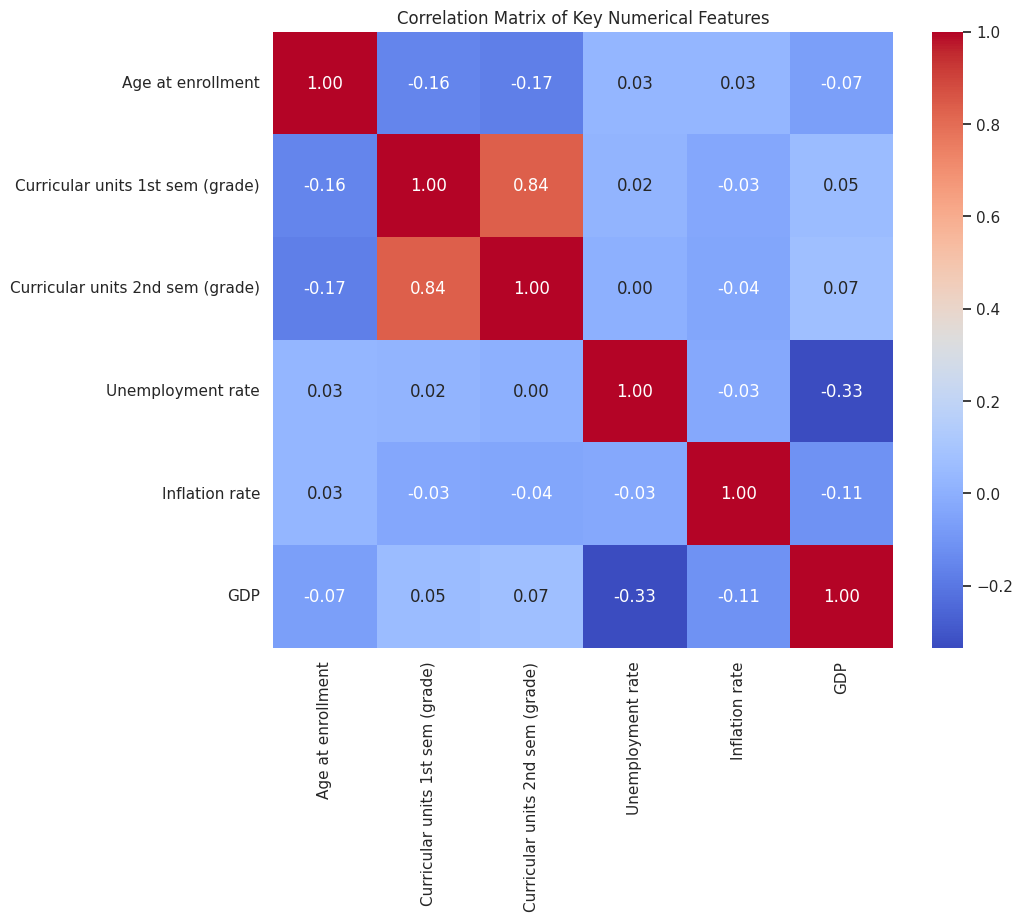

In [ ]:
# Correlation Heatmap (Numerical Features)
# We select key numerical columns to see correlations
corr_cols = ['Age at enrollment', 'Curricular units 1st sem (grade)',
             'Curricular units 2nd sem (grade)', 'Unemployment rate', 'Inflation rate', 'GDP']
plt.figure(figsize=(10, 8))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Numerical Features')
plt.show()

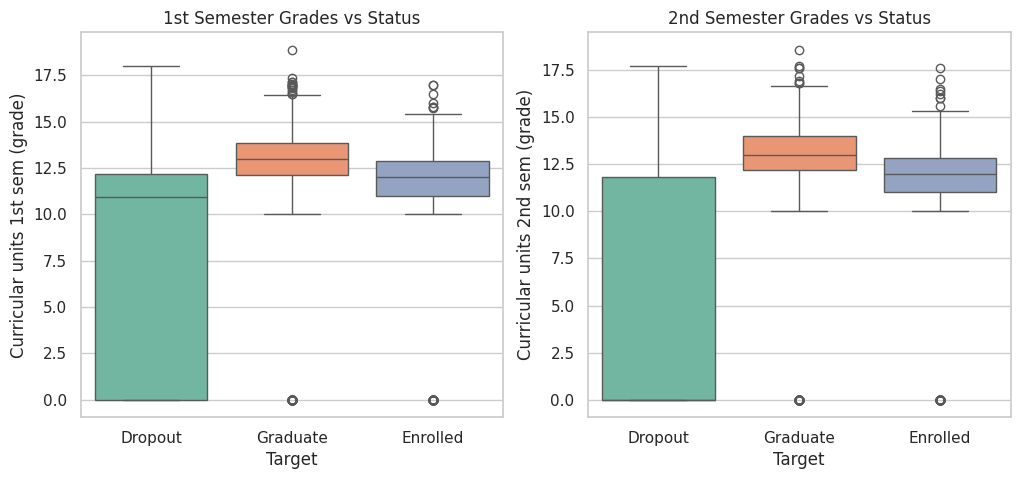

In [ ]:
# Boxplot: Academic Performance vs Dropout
# Do students with lower grades tend to dropout?
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='Target', y='Curricular units 1st sem (grade)', data=df, palette='Set2')
plt.title('1st Semester Grades vs Status')

plt.subplot(1, 2, 2)
sns.boxplot(x='Target', y='Curricular units 2nd sem (grade)', data=df, palette='Set2')
plt.title('2nd Semester Grades vs Status')
plt.show()

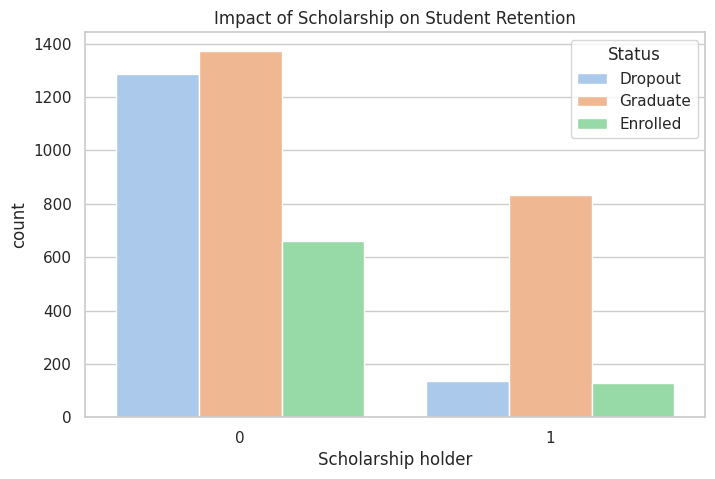

In [ ]:
# Bar Chart: Impact of Scholarships
# Does financial aid reduce dropout rates?
plt.figure(figsize=(8, 5))
sns.countplot(x='Scholarship holder', hue='Target', data=df, palette='pastel')
plt.title('Impact of Scholarship on Student Retention')
plt.legend(title='Status', loc='upper right')
plt.show()

In [ ]:
# 3.2 Encoding Target Variable
# Focus on identifying 'Dropout' (Class 1) vs 'Non-Dropout' (Class 0)
df['Target_Binary'] = df['Target'].apply(lambda x: 1 if x == 'Dropout' else 0)

# 3.3 Feature Selection (X) and Target (y)
X = df.drop(['Target', 'Target_Binary'], axis=1)
y = df['Target_Binary']

# 3.4 Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3.5 Feature Scaling
# Essential for algorithm convergence and performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training Features Shape: {X_train_scaled.shape}")
print(f"Testing Features Shape: {X_test_scaled.shape}")

Training Features Shape: (3535, 34)
Testing Features Shape: (884, 34)


4: Handling Imbalanced Data (SMOTE)

Addressing the class imbalance problem to prevent model bias.

In [ ]:
# 4.1 Apply SMOTE (Synthetic Minority Over-sampling Technique)
# Note: SMOTE is applied ONLY to the training set to prevent data leakage.
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# 4.2 Verify Class Balance
print("--- Class Distribution Before vs After SMOTE ---")
print(f"Original Dropout Counts: {sum(y_train == 1)}")
print(f"Resampled Dropout Counts: {sum(y_train_resampled == 1)}")

--- Class Distribution Before vs After SMOTE ---
Original Dropout Counts: 1137
Resampled Dropout Counts: 2398


5: Model Training (Random Forest)

Training the classifier.

In [ ]:
# 5.1 Initialize Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 5.2 Train the Model
print("Training the model... Please wait.")
rf_model.fit(X_train_resampled, y_train_resampled)
print(" Model Training Completed.")

# 5.3 Generate Predictions
y_pred = rf_model.predict(X_test_scaled)
y_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

Training the model... Please wait.
 Model Training Completed.


6: Model Evaluation

Assessing performance using professional metrics.

In [ ]:
# 6.1 Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       600
           1       0.84      0.78      0.81       284

    accuracy                           0.88       884
   macro avg       0.87      0.86      0.86       884
weighted avg       0.88      0.88      0.88       884



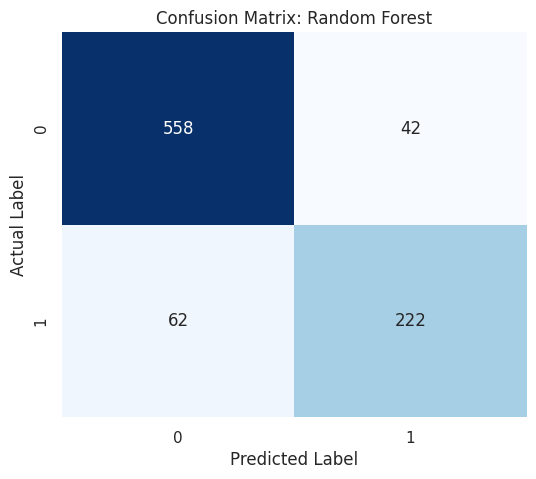

In [ ]:
# 6.2 Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

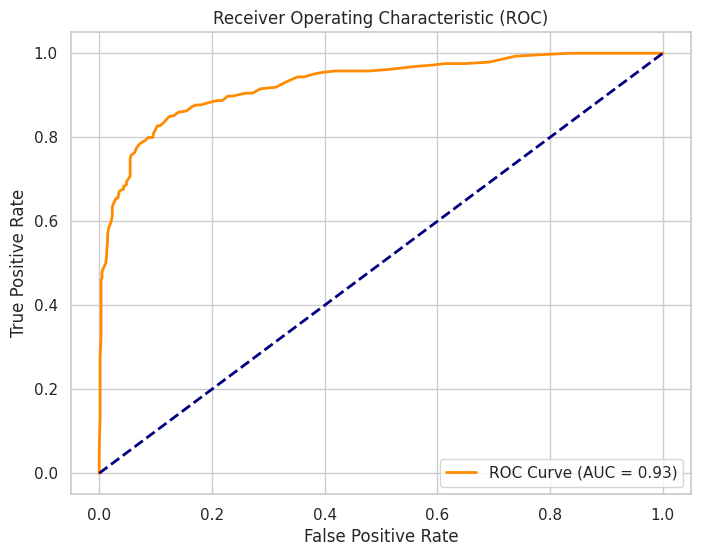

 Final ROC-AUC Score: 0.93


In [ ]:
# 6.3 ROC-AUC Curve
auc_score = roc_auc_score(y_test, y_probs)
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f" Final ROC-AUC Score: {auc_score:.2f}")

7: Business Insights (Feature Importance)

Translating model logic into actionable business advice.

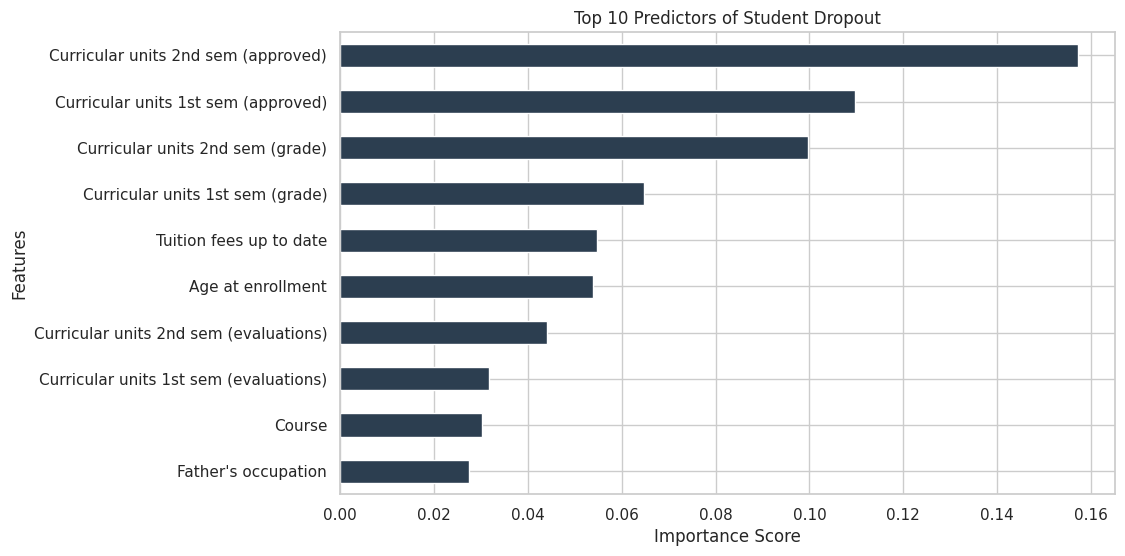

In [ ]:
# 7.1 Extract Feature Importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)

# 7.2 Plot Top 10 Features
plt.figure(figsize=(10, 6))
feature_importance.nlargest(10).plot(kind='barh', color='#2c3e50')
plt.title('Top 10 Predictors of Student Dropout')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis() # Invert y-axis to show the most important at the top
plt.show()

8: Model Deployment Preparation

Saving the model for production use.

In [ ]:
# 8.1 Save Model and Scaler
joblib.dump(rf_model, 'student_dropout_model.pkl')
joblib.dump(scaler, 'student_scaler.pkl')

print(" System files saved successfully:")
print("1. student_dropout_model.pkl")
print("2. student_scaler.pkl")

 System files saved successfully:
1. student_dropout_model.pkl
2. student_scaler.pkl
